# Estudio del modelo optimizado vs el modelo default

In [1]:
# importamos las librerías a utilizar
import pandas as pd
import numpy as np

# Configuracion de las rutas para lograr las importaciones

In [2]:
import sys
import os

# obtiene la ruta absoluta del directorio 'src' desde la ubicación del notebook
src_path = os.path.abspath(os.path.join('..', 'src'))

# agrega la ruta a 'src' al sys.path si no está ya presente
if src_path not in sys.path:
    sys.path.append(src_path)

# Cargamos los datos pre-procesados

In [3]:
from src.constants import X_TRAIN_PATH, X_TEST_PATH, Y_TRAIN_PATH, Y_TEST_PATH

# save the processed data to their corresponding files
X_train = pd.read_csv(filepath_or_buffer=X_TRAIN_PATH, sep=',')
X_test = pd.read_csv(filepath_or_buffer=X_TEST_PATH, sep=',')

y_train = pd.read_csv(filepath_or_buffer=Y_TRAIN_PATH, sep=',')
y_train = y_train['is_canceled'].to_numpy()

y_test = pd.read_csv(filepath_or_buffer=Y_TEST_PATH, sep=',')
y_test = y_test['is_canceled'].to_numpy()

# Cargamos los modelos

Cargamos el mdelo default

In [4]:
import pickle

default_model_file = '../models/default_model.pkl'

with open(default_model_file, 'rb') as file:
    def_model = pickle.load(file)

In [5]:
def_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Ahora cargamos el modelo optimizado

In [6]:
opt_model_file = '../models/opt_model.pkl'

with open(opt_model_file, 'rb') as file:
    opt_model = pickle.load(file)

In [7]:
opt_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

# Comparacion del desempeno de ambos modelos

## Realizamos las predicciones con cada modelo

In [8]:
# cargamos el mejor threshold encontrado
threshold = 0.4244231986148017

In [9]:
# realizamos la prediccion con el modelo default y el mejor threshold encontrado
def_y_prob = def_model.predict_proba(X_test)[:, 1]
def_y_pred = (def_y_prob >= threshold).astype(int)

In [10]:
# realizamos la prediccion con el modelo optimizado
opt_y_prob = opt_model.predict_proba(X_test)[:, 1]
opt_y_pred = opt_model.predict(X_test)

## Matrices de confusion


Comparacion de las matrices de confusion:


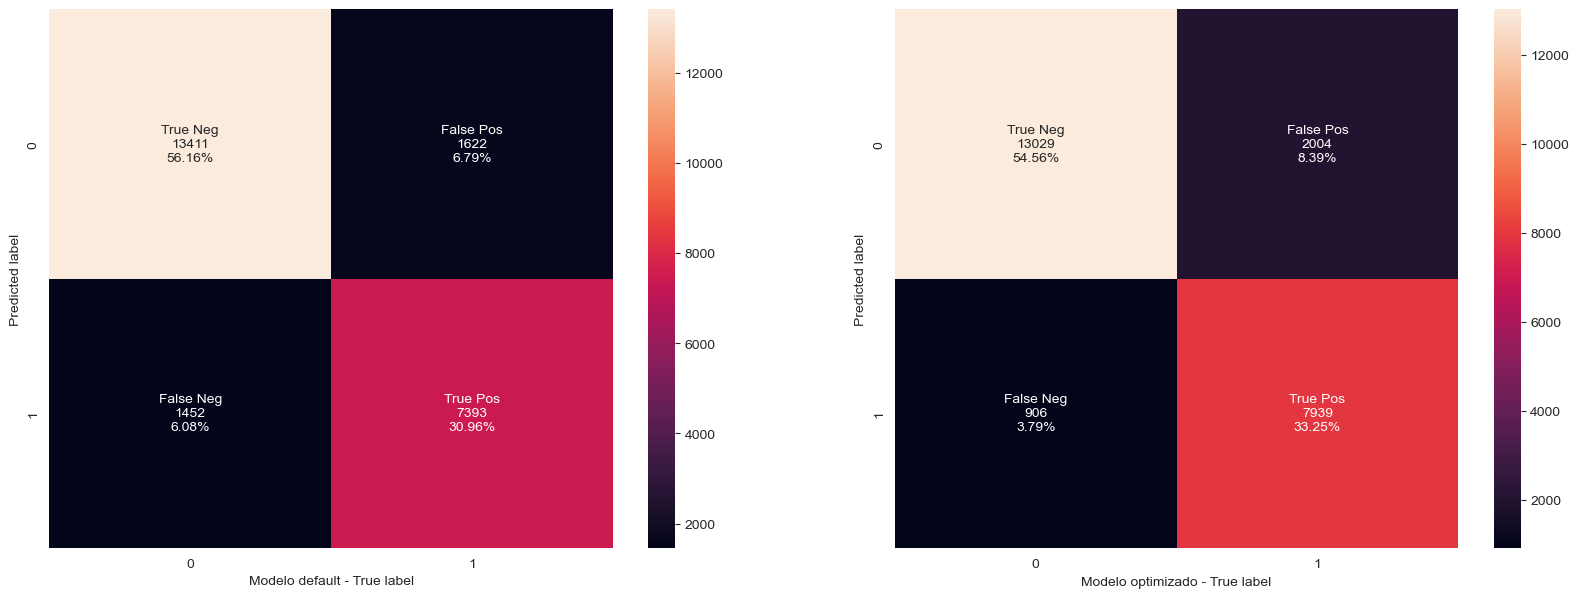

<Figure size 1000x500 with 0 Axes>

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
from src.draw_utils import draw_comparison_confusion_matrices


# calculamos las matrices de confusion
def_conf_matrix = confusion_matrix(y_test, def_y_pred)
opt_conf_matrix = confusion_matrix(y_test, opt_y_pred)

print("\nComparacion de las matrices de confusion:")

draw_comparison_confusion_matrices(
    confusion_1=def_conf_matrix,
    confusion_2=opt_conf_matrix,
    confusion_matrix_1_name='Modelo default',
    confusion_matrix_2_name='Modelo optimizado'
)

Podemos observar que el modelo optimizado tiene un mejor desempeño en la clase positiva (cancelaciones) pero un peor desempeño en la clase negativa (no cancelaciones). Esto es algo esperado ya que el modelo fue optimizado para mejorar el recall de la clase positiva. Se tomo esta decision ya que es mas importante para el negocio identificar a los clientes que cancelan, porque esto puede tener un impacto significativo en la planificación y la gestión de ingresos del hotel.

## Metrica ROC AUC

Comparamos la metrica ROC AUC de ambos modelos.

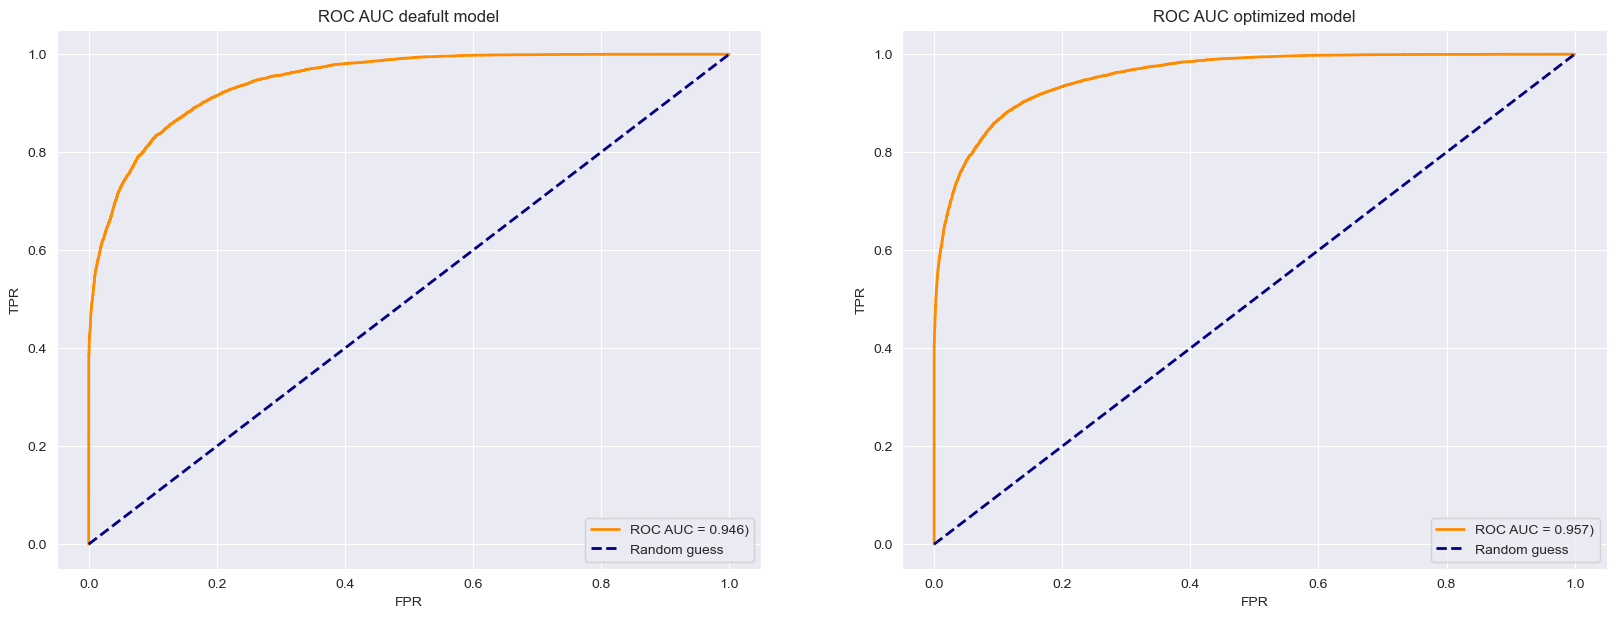

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# calculate the metrics of the default model
fpr_def, tpr_def, thresholds_def = roc_curve(y_test, def_y_prob)
roc_auc_def = auc(fpr_def, tpr_def)

# calculate the metrics of the optimized model
fpr_opt, tpr_opt, thresholds_opt = roc_curve(y_test, opt_y_prob)
roc_auc_opt = auc(fpr_opt, tpr_opt)

_, axis = plt.subplots(1, 2, figsize=(20, 7))

# graph the curve for the default model
axis[0].plot(fpr_def, tpr_def, color='darkorange', lw=2, label=f"ROC AUC = {roc_auc_def:.3f})")
axis[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=f"Random guess") # random plot
axis[0].set_title("ROC AUC deafult model")
axis[0].legend(loc="lower right")
axis[0].grid(True)


# graph the curve for the optimized model
axis[1].plot(fpr_opt, tpr_opt, color='darkorange', lw=2, label=f"ROC AUC = {roc_auc_opt:.3f})")
axis[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=f"Random guess") # random plot
axis[1].set_title("ROC AUC optimized model")
axis[1].legend(loc="lower right")
axis[1].grid(True)

for ax in axis.flat:
    ax.set(xlabel='FPR', ylabel='TPR')

plt.show()

Podemos observar un mejor desempeno por parte del modelo optimizado.

## Grafico precision - recall

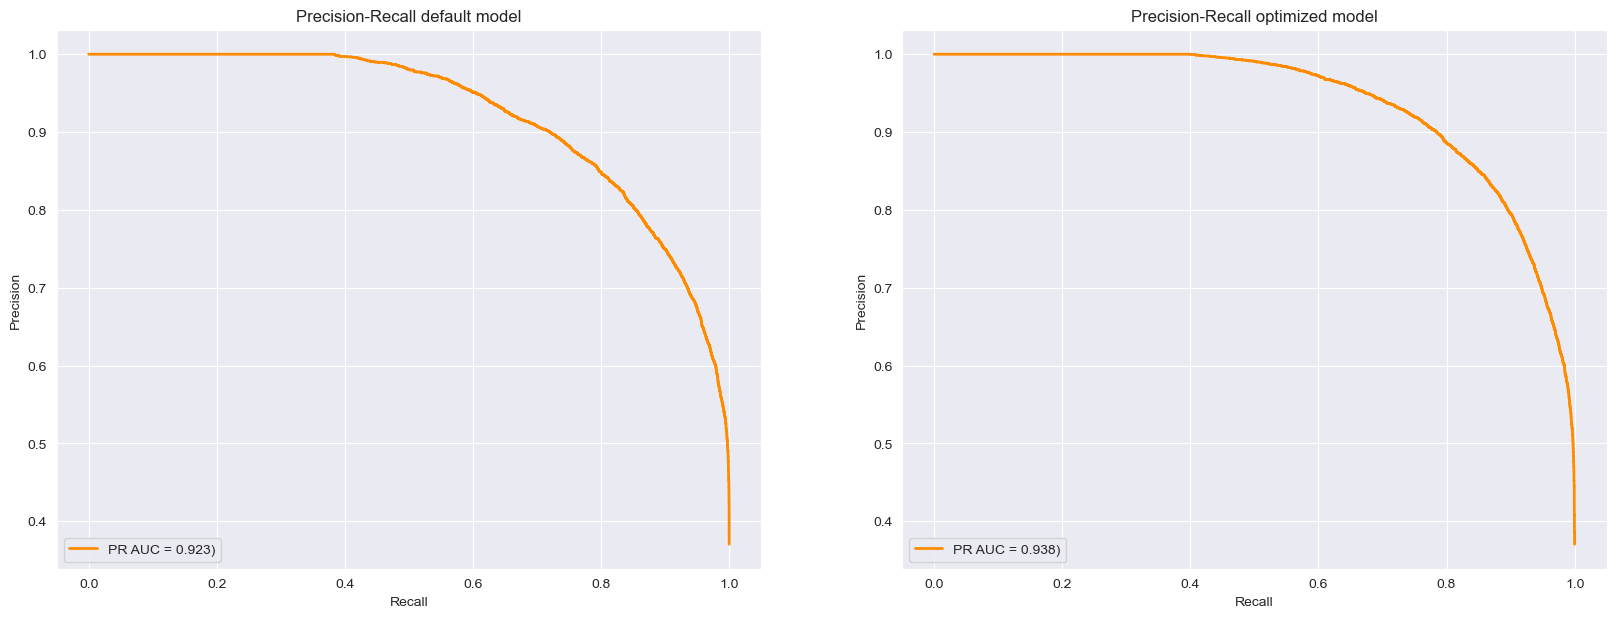

In [13]:
from sklearn.metrics import precision_recall_curve, average_precision_score


# calculate the metrics of the default model
precision_def, recall_def, thresholds_pr_def = precision_recall_curve(y_test, def_y_prob)
pr_auc_def = average_precision_score(y_test, def_y_prob)

# calculate the metrics of the optimized model
precision_opt, recall_opt, thresholds_pr_opt = precision_recall_curve(y_test, opt_y_prob)
pr_auc_opt = average_precision_score(y_test, opt_y_prob)

_, axis = plt.subplots(1, 2, figsize=(20, 7))

# graph the curve for the default model
axis[0].plot(recall_def, precision_def, color='darkorange', lw=2, label=f"PR AUC = {pr_auc_def:.3f})")
axis[0].set_title('Precision-Recall default model')
axis[0].legend(loc='lower left')


# graph the curve for the optimized model
axis[1].plot(recall_opt, precision_opt, color='darkorange', lw=2, label=f"PR AUC = {pr_auc_opt:.3f})")
axis[1].set_title('Precision-Recall optimized model')
axis[1].legend(loc='lower left')

for ax in axis.flat:
    ax.set(xlabel='Recall', ylabel='Precision')

plt.show()

Podemos observar que el modelo optimizado posee un mejor desempeno de Precisio y Recall, de forma que se desempena mejor con la clase positiva (cancelaciones) ajustandose de mejor manera a los datos desbalanceados.

# Conclusion final